In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DATA_DIR = r"D:\d backup\M_TECH\SEM1\Hackathon_papers\FINAL_CODE\tomato\train"
VAL_DATA_DIR = r"D:\d backup\M_TECH\SEM1\Hackathon_papers\FINAL_CODE\tomato\train"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    VAL_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_gen.num_classes


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [14]:
import json

class_names = list(train_gen.class_indices.keys())
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved:", class_names)


Saved: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [25]:
from tensorflow.keras import layers, models

def eca_block(inputs, gamma=2, b=1):
    channels = inputs.shape[-1]
    import tensorflow as tf
    t = int(abs((tf.math.log(tf.cast(channels, tf.float32)) / tf.math.log(2.0)) + b) / gamma)
    k = t if t % 2 else t + 1
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    avg_pool = layers.Reshape((channels,1))(avg_pool)
    conv1 = layers.Conv1D(1, kernel_size=k, padding="same", use_bias=False)(avg_pool)
    conv1 = layers.Activation("sigmoid")(conv1)
    conv1 = layers.Reshape((1,1,channels))(conv1)
    return layers.Multiply()([inputs, conv1])

# ---------

In [30]:
IMG_SIZE = 224 
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = eca_block(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = eca_block(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = eca_block(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = eca_block(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 1)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 32, 1)     │          3 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 1)     │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 64, 1)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 1)     │          3 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 1)     │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 64)               │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ multiply_1[0][0]

 Total params: 13,238,234 (50.50 MB)

 Trainable params: 13,237,274 (50.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [31]:
# ----------------------
# Callbacks
# ----------------------
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("tomato_cnn_eca_best.h5", monitor="val_accuracy", save_best_only=True)
]

# ----------------------
# Train
# ----------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5322 - loss: 1.5404

500/500 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.6192 - loss: 1.1952 - val_accuracy: 0.3380 - val_loss: 2.8892 - learning_rate: 1.0000e-04
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7257 - loss: 0.8217

500/500 ━━━━━━━━━━━━━━━━━━━━ 1789s 4s/step - accuracy: 0.7398 - loss: 0.7953 - val_accuracy: 0.8255 - val_loss: 0.5465 - learning_rate: 1.0000e-04
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7787 - loss: 0.6759

500/500 ━━━━━━━━━━━━━━━━━━━━ 904s 2s/step - accuracy: 0.7891 - loss: 0.6523 - val_accuracy: 0.8540 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8125 - loss: 0.5770

500/500 ━━━━━━━━━━━━━━━━━━━━ 804s 2s/step - accuracy: 0.8126 - loss: 0.5789 - val_accuracy: 0.8890 - val_loss: 0.3141 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.8232 - loss: 0.5325 - val_accuracy: 0.8870 - val_loss: 0.3524 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8475 - loss: 0.4791
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.8430 - loss: 0.4909 - val_accuracy: 0.8395 - val_loss: 0.5191 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8837 - loss: 0.3506

500/500 ━━━━━━━━━━━━━━━━━━━━ 870s 2s/step - accuracy: 0.8836 - loss: 0.3457 - val_accuracy: 0.9155 - val_loss: 0.2715 - learning_rate: 5.0000e-05
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8914 - loss: 0.3183

500/500 ━━━━━━━━━━━━━━━━━━━━ 885s 2s/step - accuracy: 0.8945 - loss: 0.3076 - val_accuracy: 0.9365 - val_loss: 0.1970 - learning_rate: 5.0000e-05
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.9004 - loss: 0.2955 - val_accuracy: 0.8980 - val_loss: 0.3353 - learning_rate: 5.0000e-05
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9092 - loss: 0.2697

500/500 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - accuracy: 0.9110 - loss: 0.2798 - val_accuracy: 0.9455 - val_loss: 0.1716 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.


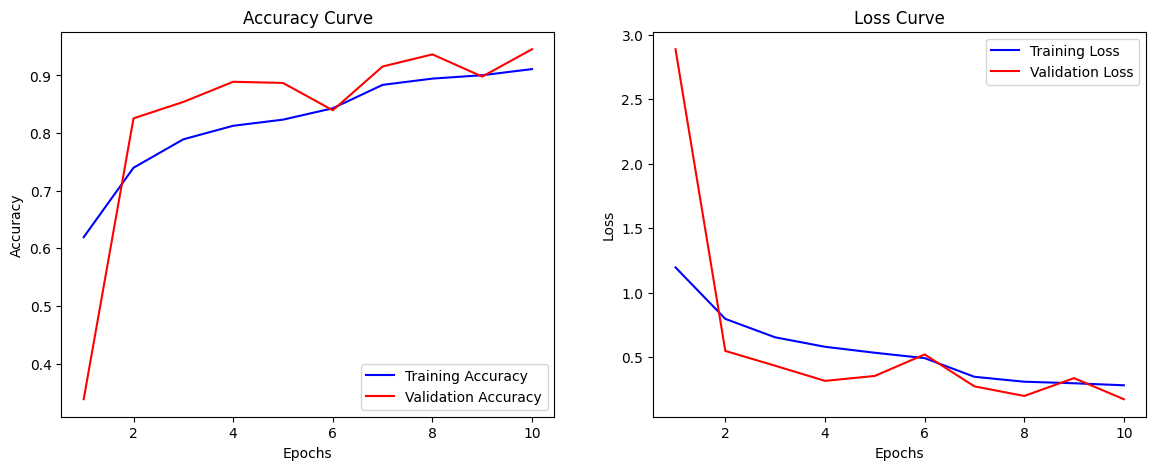

In [37]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_training_curves(history)


In [38]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.9460 - loss: 0.1812
Validation Accuracy: 94.60%
Validation Loss: 0.1812


125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step


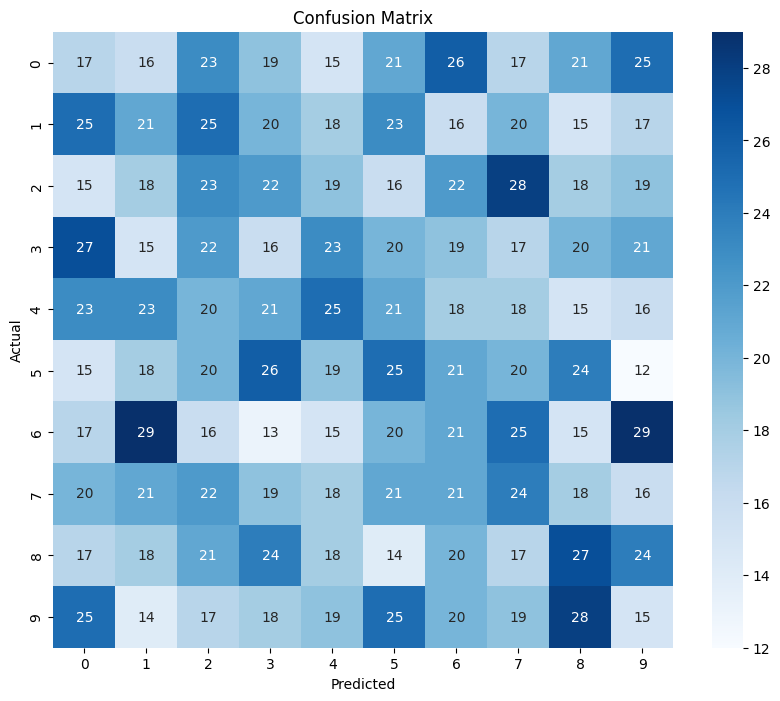

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
true_labels = val_gen.classes
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [42]:
class_names = list(train_gen.class_indices.keys())

print(classification_report(true_labels, pred_labels, target_names=class_names))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.08      0.09      0.08       200
                        Tomato___Early_blight       0.11      0.10      0.11       200
                         Tomato___Late_blight       0.11      0.12      0.11       200
                           Tomato___Leaf_Mold       0.08      0.08      0.08       200
                  Tomato___Septoria_leaf_spot       0.13      0.12      0.13       200
Tomato___Spider_mites Two-spotted_spider_mite       0.12      0.12      0.12       200
                         Tomato___Target_Spot       0.10      0.10      0.10       200
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.12      0.12      0.12       200
                 Tomato___Tomato_mosaic_virus       0.13      0.14      0.13       200
                             Tomato___healthy       0.08      0.07      0.08       200

                                     accu

In [ ]:
model.save("tomato_disease_CNN_model2.h5")

In [46]:
import matplotlib.pyplot as plt

def summary_to_png(model, filename="model_summary.png"):
    summary_lines = []
    model.summary(print_fn=lambda x: summary_lines.append(x))
    
    text = "\n".join(summary_lines)

    plt.figure(figsize=(12, 12))
    plt.text(0.01, 0.99, text, fontsize=10, va="top", family="monospace")
    plt.axis("off")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", filename)

summary_to_png(model)


Saved: model_summary.png
